In [4]:
from collections import deque 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from river import cluster as river_cluster
from river import stream
from river.utils import dict2numpy
from collections import Counter
from tqdm import tqdm
import time

# FastCOMPOSE pipeline with improvement 1

In [5]:
class FastCOMPOSE:
    def __init__(self, data, labels, training_set_size):
        ### OK
        self.training_set_size = training_set_size
        self.training_set_data = deque()
        self.training_set_labels = deque()
        self.clusters = None
        
        for i, (x, y) in enumerate(stream.iter_array(data, labels)):
            # Add labeled data to the training set
            self._add_data_to_training_set([(x, y)])
        
        # Train on training set
        self._train_on_training_set()
            
    def _calculate_accuracy(self, data, labels):
        ### OK
        # Calculate accuracy on current batch
        accuracy = 0
        accuracy_per_class = {label: [] for label in np.unique(labels)}
            
        for i, (x, y) in enumerate(stream.iter_array(data, labels)):
            cluster = self._predict_clustering(x)
            y_pred = self.clusters[cluster]["cluster_label"]
            accuracy += (y == y_pred)
            accuracy_per_class[y].append(y == y_pred)
            
        accuracy /= len(data)
        accuracy_per_class = {label: np.mean(scores) for label, scores in accuracy_per_class.items()}
        
        return accuracy, accuracy_per_class
            
    def _add_data_to_training_set(self, labeled_data):
        ### OK
        for x, y in labeled_data:
            if self.training_set_size and len(self.training_set_data) == self.training_set_size:
                self.training_set_data.popleft()
                self.training_set_labels.popleft()
            self.training_set_data.append(dict2numpy(x))
            self.training_set_labels.append(y)
            
    def _create_clusters(self):
        ### OK
        self.clusters = {idx: {"data": [], "labels": [], "cluster_label": None} for idx in range(self.n_clusters)}

        for i, (x, y) in enumerate(stream.iter_array(self.training_set_data, self.training_set_labels)):
            cluster = self._predict_clustering(x)
            self.clusters[cluster]["data"].append(x)
            self.clusters[cluster]["labels"].append(y)

        # Retrain with smaller number of clusters if empty clusters created
        if np.any([not cluster["labels"] for idx, cluster in self.clusters.items()]):
            return 1

        # Label clusters by majority voting
        for cluster_idx in self.clusters.keys():
            cluster_label = max(set(self.clusters[cluster_idx]["labels"]),
                                key=self.clusters[cluster_idx]["labels"].count)
            self.clusters[cluster_idx]["cluster_label"] = cluster_label

        return 0
            
    def _train_clustering(self, x):
        ### OK
        self.clustering_algorithm = self.clustering_algorithm.learn_one(x)
            
    def _predict_clustering(self, x):
        ### OK
        cluster = self.clustering_algorithm.predict_one(x)
        return cluster
    
    def _train_on_training_set(self):
        ### OK
        previous_clusters = self.clusters
        
        self.n_clusters = 5
        self.clustering_algorithm = river_cluster.KMeans(n_clusters=self.n_clusters)
        
        for i, (x, y) in enumerate(stream.iter_array(self.training_set_data, self.training_set_labels)):
            self._train_clustering(x)
        retrain = self._create_clusters()
            
        # If some clusters are empty retrain model with smaller number of clusters
        while retrain:
            self.n_clusters -= 1
            self.clustering_algorithm = river_cluster.KMeans(n_clusters=self.n_clusters)
            
            print(f"Number of clusters = {self.n_clusters}")
            
            for i, (x, y) in enumerate(stream.iter_array(self.training_set_data, self.training_set_labels)):
                self._train_clustering(x)
            retrain = self._create_clusters()
            
        # If some class is going to be lost keep it in the cluster with the highest proportion of this class
        if previous_clusters:
            classes_in_current_clusters = np.unique(
                [cluster["cluster_label"] for cluster in list(self.clusters.values())])
            classes_in_previous_clusters = np.unique(
                [cluster["cluster_label"] for cluster in list(previous_clusters.values())])

            if not np.array_equal(classes_in_current_clusters, classes_in_previous_clusters) and len(self.clusters) == len(previous_clusters):
                for class_ in classes_in_previous_clusters:
                    if class_ not in classes_in_current_clusters:
                        missing_class_proportions = {idx: Counter(cluster["labels"])[class_] / len(cluster["labels"])
                                                     for idx, cluster in list(self.clusters.items())}
                        cluster_to_keep_class = max(missing_class_proportions, key=missing_class_proportions.get)
                        self.clusters[cluster_to_keep_class]["cluster_label"] = class_
            
            
    def _cluster_and_label_step(self, data, labels):
        ### OK
        data_with_labels = []
        
        for i, (x, _) in enumerate(stream.iter_array(data, labels)):            
            cluster = self._predict_clustering(x)
            y = self.clusters[cluster]["cluster_label"]
            data_with_labels.append((x, y))
        
        # Add newly labeled data to the training set
        self._add_data_to_training_set(data_with_labels)
        
        self._train_on_training_set()
        
    def plot_clusters(self, print_label_counts_in_clusters):  
        ### OK
        data_dim = self.training_set_data[0].shape[0]
            
        # Plot 3D data
        if data_dim == 3:
            fig = plt.figure()
            ax = fig.add_subplot(projection='3d')

        for idx, cluster in self.clusters.items():
            labels = cluster["labels"]
            # Skip empty clusters
            if len(labels) == 0:
                continue
            label = cluster["cluster_label"]
            cluster = np.vstack([list(data_element.values()) for data_element in cluster["data"]])
            # Plot 3D data
            if data_dim == 3:
                ax.scatter(cluster[:, 0], cluster[:, 1], cluster[:, 2], label=label)
            # Plot 2D data
            else:
                plt.scatter(cluster[:, 0], cluster[:, 1], label=label)
                
            if print_label_counts_in_clusters:
                counter = Counter(labels)
                print(dict(counter))
        
        plt.title("Clusters from training set with labels")
        plt.legend()
        plt.show()
                    
    def __call__(self, data, labels):
        ### OK
        self._cluster_and_label_step(data, labels)
        accuracy, accuracy_per_class = self._calculate_accuracy(data, labels)
        return accuracy, accuracy_per_class

In [6]:
def plot_incoming_data(data, labels):
    unique_labels = np.unique(labels)
    data_dim = data.shape[1]
    
    # Plot 3D data
    if data.shape[1] == 3:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
    
    for label in unique_labels:
        # Plot 3D data
        if data_dim == 3:
            ax.scatter(data[labels == label][:, 0], data[labels == label][:, 1], data[labels == label][:, 2], label=label)
        # Plot 2D data
        else:
            plt.scatter(data[labels == label][:, 0], data[labels == label][:, 1], label=label)
    
    plt.title("Data from current batch with labels")
    plt.legend()
    plt.show()

In [7]:
def train_fast_compose(streaming_data, streaming_labels, training_set_size=1000, print_interval=50, print_label_counts_in_clusters=False):
    # Assume first batch (streaming_data[0], streaming_labels[0]) to be labelled to initialize algorithm
    accuracies = []
    accuracies_per_class = {label: [] for label in np.unique(streaming_labels)}
    start = time.time()

    fc = FastCOMPOSE(streaming_data[0], streaming_labels[0], training_set_size)

    for batch_idx, (data, labels) in tqdm(enumerate(zip(streaming_data[1:], streaming_labels[1:]), 1)):
        accuracy, accuracy_per_class = fc(data, labels)
        accuracies.append(accuracy)
        for label, accuracy in accuracy_per_class.items():
            accuracies_per_class[label].append(accuracy)
        # If class not present in current batch set accuracy for that class to None
        for label in accuracies_per_class.keys():
            if label not in accuracy_per_class.keys():
                accuracies_per_class[label].append(None)

    #     print(batch_idx, accuracy)

        if batch_idx % print_interval == 0:
            fc.plot_clusters(print_label_counts_in_clusters)
            plot_incoming_data(data, labels)

    end = time.time()
    print(f"Time elapsed: {end - start}")
    
    plt.plot(accuracies)
    plt.title("Accuracy")
    plt.show()
    
    for label, accuracy in accuracies_per_class.items():
        plt.plot(accuracy, label=f"{label}")
    plt.title("Accuracy per class")
    plt.legend()
    plt.show()
    
    return fc, accuracies, accuracies_per_class

# Experiments 2D

In [8]:
dataset_2d = "./2d_gaussian_data_v2.csv"

In [9]:
gaussian_data_2d = pd.read_csv(dataset_2d)
y_2d = gaussian_data_2d.pop('label').to_numpy()
X_2d = gaussian_data_2d.to_numpy()

In [10]:
X_2d.shape

(26300, 2)

In [11]:
y_2d.shape

(26300,)

In [12]:
for xi, yi in stream.iter_array(X_2d, y_2d):
    print(xi, yi)
    break

{0: 1.3084041099825865, 1: 5.271207619270895} 0


In [13]:
streaming_data_2d = np.split(X_2d, X_2d.shape[0]/100)
streaming_labels_2d = np.split(y_2d, y_2d.shape[0]/100)

In [14]:
streaming_data_2d[0].shape

(100, 2)

In [15]:
streaming_labels_2d[0].shape

(100,)

Number of clusters = 4


24it [00:00, 24.36it/s]

{0: 283, 1: 1}
{1: 161}
{0: 20, 1: 385}
{1: 186, 0: 326}
{0: 31, 1: 107}


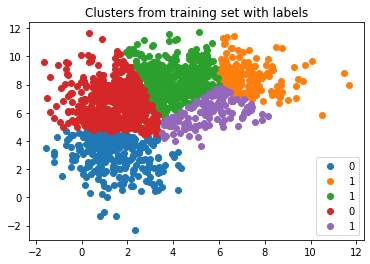

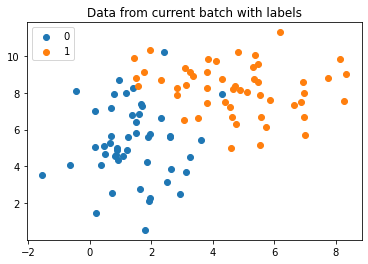

48it [00:02, 20.03it/s]

{0: 106}
{1: 424, 0: 15}
{1: 259}
{0: 212, 1: 42}
{0: 426, 1: 16}


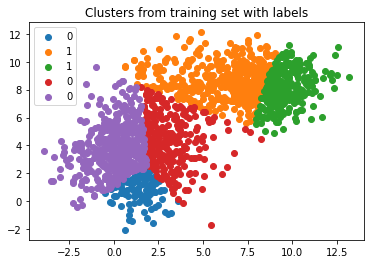

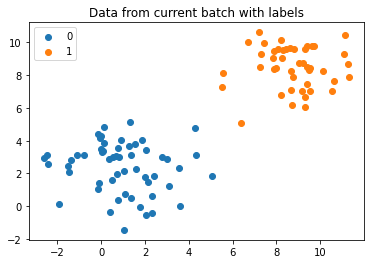

74it [00:04, 20.78it/s]

{1: 236}
{1: 513}
{0: 347}
{0: 251}
{0: 152, 1: 1}


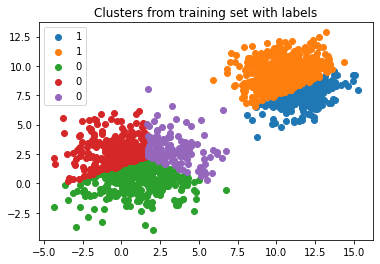

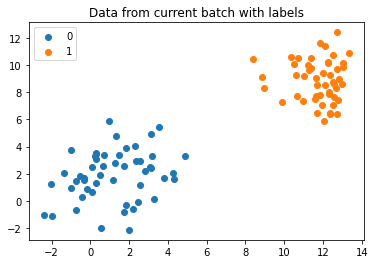

98it [00:05, 20.71it/s]

{1: 390}
{0: 230}
{1: 298, 0: 1}
{0: 274}
{1: 291, 0: 16}


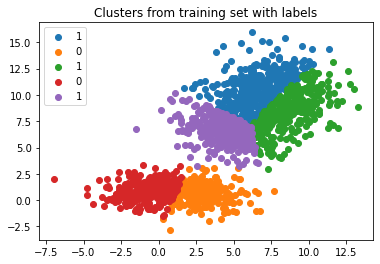

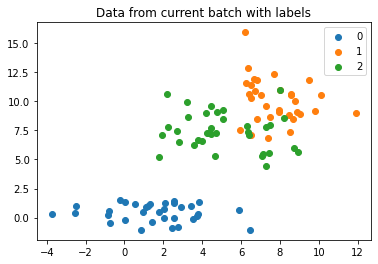

122it [00:06, 20.65it/s]

{0: 272, 1: 2}
{1: 224, 0: 3}
{1: 273, 0: 1}
{1: 481}
{0: 242, 1: 2}


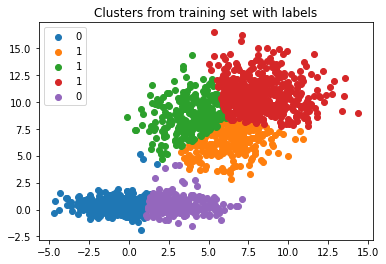

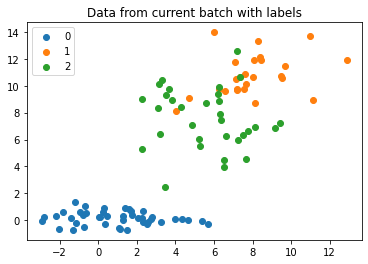

148it [00:08, 20.62it/s]

{1: 160}
{1: 403}
{0: 171, 1: 92}
{1: 166, 0: 61}
{0: 377, 1: 70}


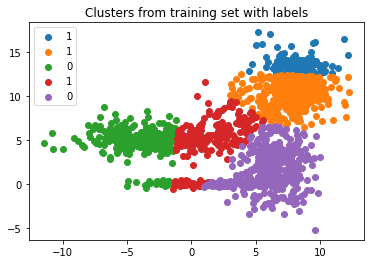

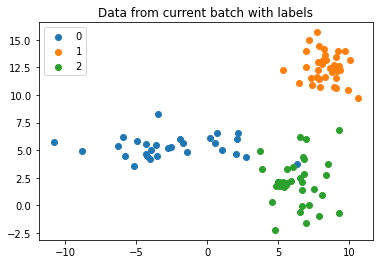

172it [00:09, 20.87it/s]

{0: 153, 1: 61}
{1: 497}
{1: 71, 0: 28}
{0: 458, 1: 11}
{1: 199, 0: 22}


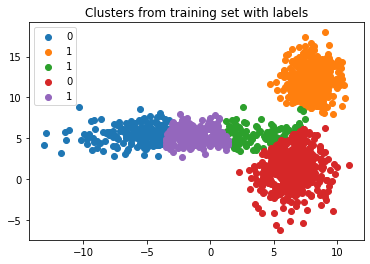

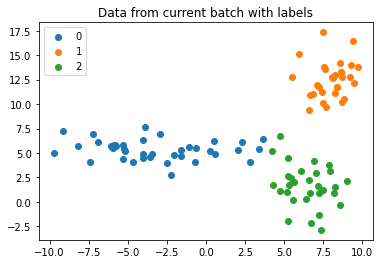

199it [00:11, 21.08it/s]

{1: 52, 0: 134}
{1: 495, 0: 20}
{1: 234, 0: 19}
{0: 354}
{0: 154, 1: 38}


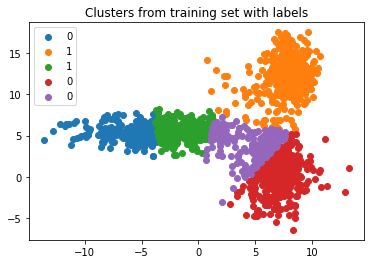

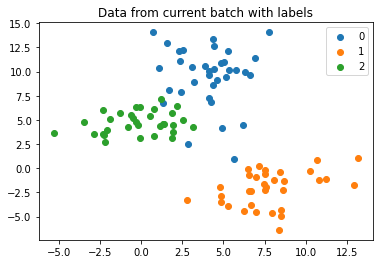

223it [00:12, 21.01it/s]

{0: 22}
{1: 329, 0: 31}
{1: 142, 0: 9}
{0: 511, 1: 1}
{0: 297, 1: 158}


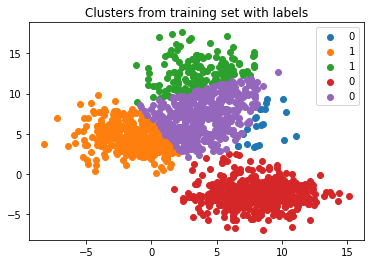

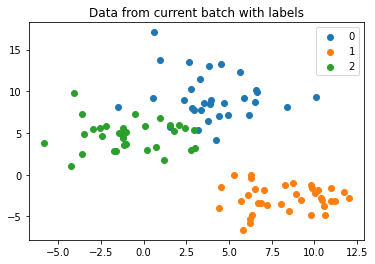

247it [00:14, 20.88it/s]

{0: 316, 1: 1}
{1: 52, 0: 104}
{0: 189}
{1: 174, 0: 341}
{1: 303, 0: 20}


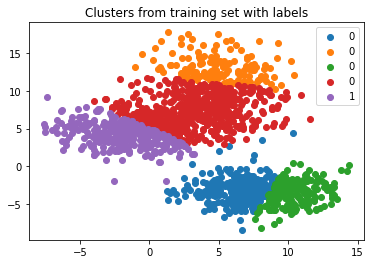

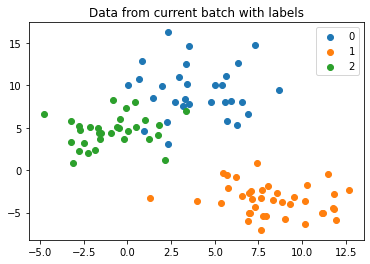

262it [00:15, 16.93it/s]


Time elapsed: 15.50336480140686


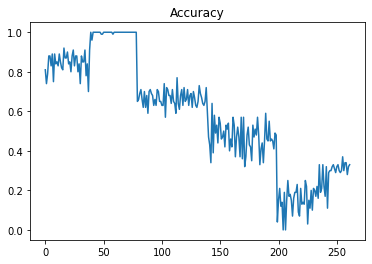

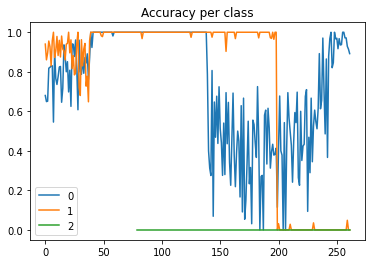

In [16]:
fc, accuracies, accuracies_per_class = train_fast_compose(streaming_data_2d, streaming_labels_2d, training_set_size=1500, print_interval=25, print_label_counts_in_clusters=True)

Number of clusters = 4


262it [00:11, 22.00it/s]

Time elapsed: 11.917027235031128


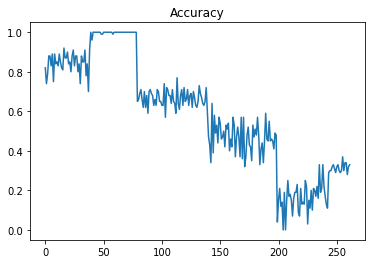

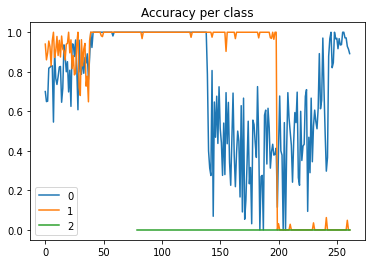

Number of clusters = 4


262it [00:12, 21.67it/s]

Time elapsed: 12.098122119903564


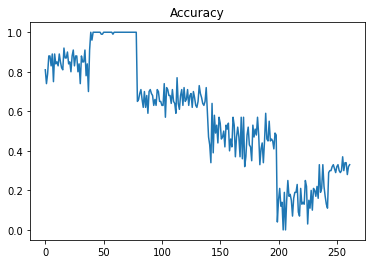

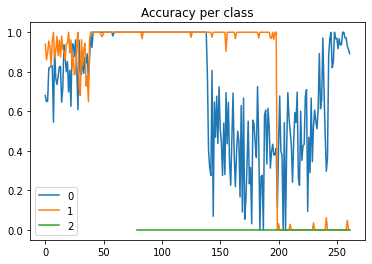

Number of clusters = 4


262it [00:11, 21.97it/s]


Time elapsed: 11.93702507019043


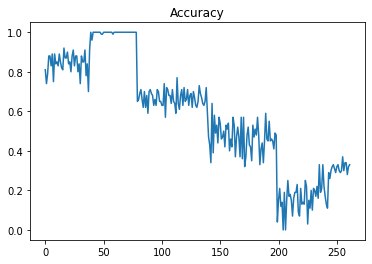

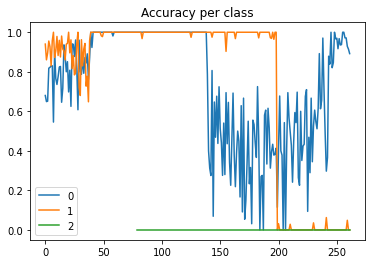

Number of clusters = 4


262it [00:12, 21.30it/s]


Time elapsed: 12.31122088432312


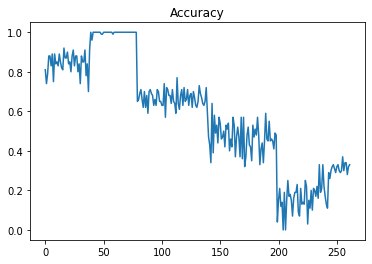

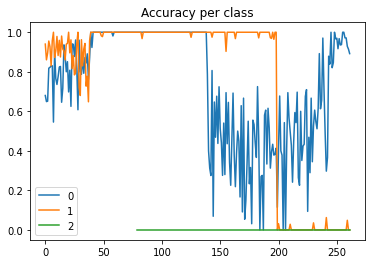

Number of clusters = 4


262it [00:12, 21.42it/s]


Time elapsed: 12.237580060958862


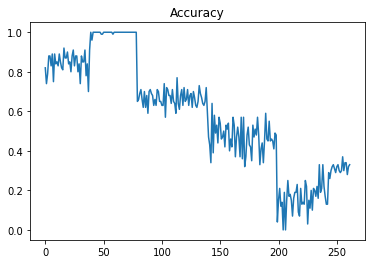

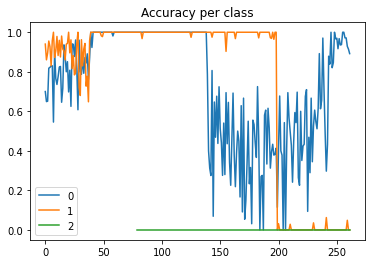

In [17]:
# Obtain averaged results
accuracy_results = []
accuracy_per_class_results = []
for i in range(5):
    fc, accuracies, accuracies_per_class = train_fast_compose(streaming_data_2d, streaming_labels_2d, training_set_size=1500, print_interval=1000, print_label_counts_in_clusters=False)
    accuracy_results.append(accuracies)
    accuracy_per_class_results.append(accuracies_per_class)

Text(0.5, 1.0, 'Accuracy averaged over 5 learning trials')

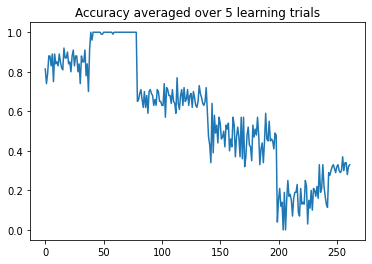

In [18]:
plt.plot(np.array(accuracy_results).mean(axis=0))
plt.title("Accuracy averaged over 5 learning trials")

In [19]:
avg_results_per_class = []
for class_ in range(3):
    result_per_class = np.array([dict_[class_] for dict_ in accuracy_per_class_results if class_ in dict_.keys()], dtype=float)
    avg_result_per_class = np.nanmean(result_per_class, axis=0)
    avg_results_per_class.append(avg_result_per_class)

<ipython-input-19-9865dfc5f3b5>:4: RuntimeWarning: Mean of empty slice
  avg_result_per_class = np.nanmean(result_per_class, axis=0)


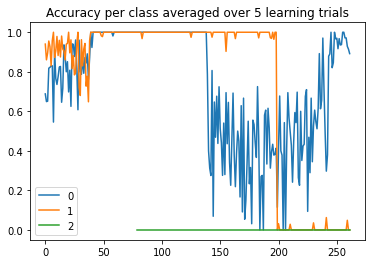

In [20]:
for class_ in range(3):
    plt.plot(avg_results_per_class[class_], label=class_)
    plt.legend()
    plt.title("Accuracy per class averaged over 5 learning trials")

# Experiments 3D

In [21]:
dataset_3d = "./3d_gaussian_data.csv"
gaussian_data_3d = pd.read_csv(dataset_3d)
y_3d = gaussian_data_3d.pop('label').to_numpy()
X_3d = gaussian_data_3d.to_numpy()

In [22]:
X_3d.shape

(20200, 3)

In [23]:
y_3d.shape

(20200,)

In [24]:
for xi, yi in stream.iter_array(X_3d, y_3d):
    print(xi, yi)
    break

{0: 8.065993314520647, 1: 2.252267979768172, 2: 5.110438424631312} 0


In [25]:
streaming_data_3d = np.split(X_3d, X_3d.shape[0]/100)
streaming_labels_3d = np.split(y_3d, y_3d.shape[0]/100)

In [26]:
streaming_data_3d[0].shape

(100, 3)

In [27]:
streaming_labels_3d[0].shape

(100,)

23it [00:01, 19.55it/s]

{0: 754, 1: 1}
{1: 147}
{1: 263}
{1: 157}
{1: 178}


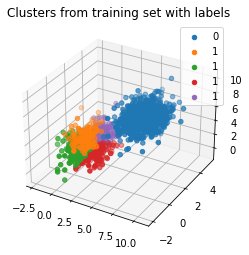

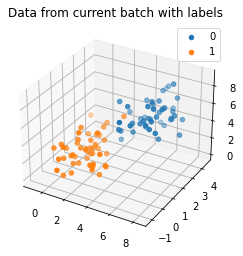

48it [00:02, 16.82it/s]

{0: 144, 1: 1}
{0: 514, 1: 2}
{1: 267, 0: 60}
{1: 173, 0: 16}
{1: 323}


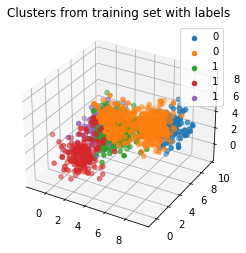

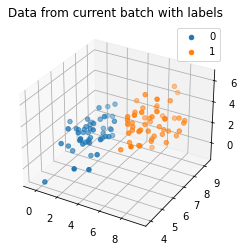

54it [00:03, 10.30it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


56it [00:03,  8.89it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


59it [00:04,  7.43it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


61it [00:04,  7.10it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


63it [00:05,  6.91it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


65it [00:05,  6.90it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


66it [00:05,  6.63it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


68it [00:05,  6.59it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


70it [00:06,  6.66it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


71it [00:06,  6.44it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


73it [00:06,  6.25it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


74it [00:06,  6.19it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
{0: 757}
{1: 742, 0: 1}


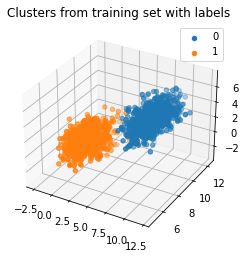

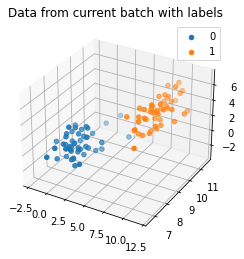

76it [00:07,  3.86it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


77it [00:07,  4.33it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


79it [00:08,  5.05it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


81it [00:08,  6.02it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4


83it [00:08,  6.59it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


85it [00:08,  6.94it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


87it [00:09,  7.11it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


89it [00:09,  7.19it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


90it [00:09,  7.24it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


92it [00:09,  7.28it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


94it [00:10,  6.77it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


95it [00:10,  6.23it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


96it [00:10,  5.85it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


98it [00:10,  5.80it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


99it [00:11,  5.86it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
{0: 751}
{1: 749}


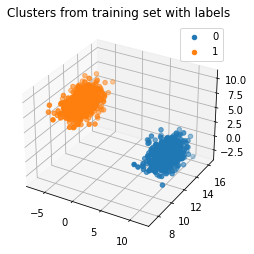

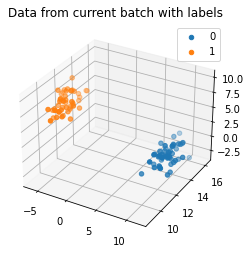

101it [00:11,  4.11it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


102it [00:11,  4.49it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


104it [00:12,  5.13it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


105it [00:12,  5.08it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


106it [00:12,  5.28it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


108it [00:12,  5.61it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


109it [00:13,  5.72it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


111it [00:13,  5.98it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


112it [00:13,  6.07it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


114it [00:13,  6.07it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4

115it [00:14,  6.13it/s]


Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


117it [00:14,  6.13it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


118it [00:14,  6.00it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


120it [00:14,  6.15it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


122it [00:15,  6.17it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4

123it [00:15,  6.19it/s]


Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


124it [00:15,  6.20it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
{1: 454}
{0: 1046}


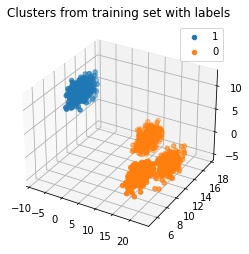

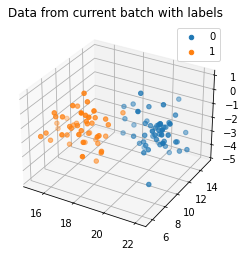

126it [00:16,  4.45it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


128it [00:16,  5.24it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4

129it [00:16,  5.52it/s]


Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


131it [00:16,  5.78it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


133it [00:17,  6.01it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


134it [00:17,  5.83it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4


135it [00:17,  5.71it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


137it [00:17,  5.62it/s]

Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1


138it [00:18,  5.58it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4


139it [00:18,  5.55it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3


140it [00:18,  5.55it/s]

Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1


142it [00:18,  5.55it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4


143it [00:19,  5.56it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3


144it [00:19,  5.49it/s]

Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


146it [00:19,  5.53it/s]

Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1


147it [00:19,  5.55it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3


148it [00:19,  5.55it/s]

Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1


149it [00:20,  5.59it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
{0: 1500}


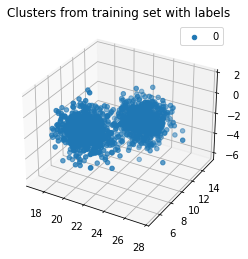

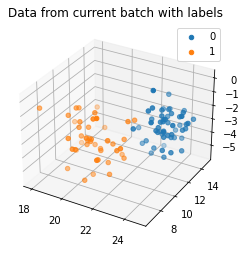

151it [00:20,  4.22it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4


152it [00:20,  4.55it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1


154it [00:21,  4.99it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4


155it [00:21,  5.16it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3


157it [00:21,  5.37it/s]

Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1


158it [00:22,  5.44it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3


160it [00:22,  5.88it/s]

Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3


162it [00:22,  6.50it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4

164it [00:22,  6.89it/s]


Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


165it [00:23,  6.99it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


167it [00:23,  7.15it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


169it [00:23,  7.31it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


171it [00:23,  7.40it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


173it [00:24,  7.43it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


174it [00:24,  6.94it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
{0: 756}
{0: 744}


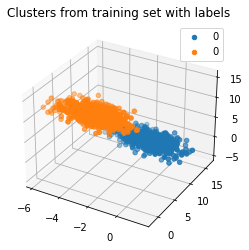

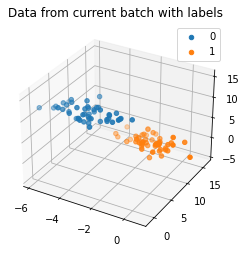

176it [00:24,  4.37it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


178it [00:25,  5.19it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


179it [00:25,  5.44it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


181it [00:25,  5.78it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


183it [00:26,  5.90it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


184it [00:26,  5.94it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


186it [00:26,  6.02it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


188it [00:26,  6.10it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


189it [00:27,  6.13it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


191it [00:27,  6.20it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


193it [00:27,  6.17it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


194it [00:27,  6.13it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


196it [00:28,  6.17it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


197it [00:28,  6.12it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


199it [00:28,  6.16it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
{0: 747}
{0: 753}


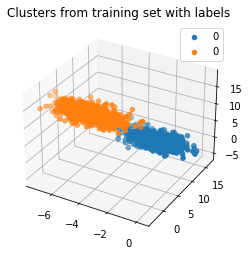

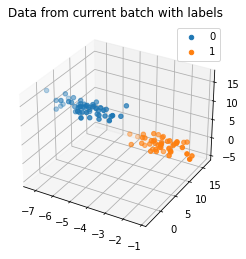

201it [00:29,  6.86it/s]


Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Time elapsed: 29.32929515838623


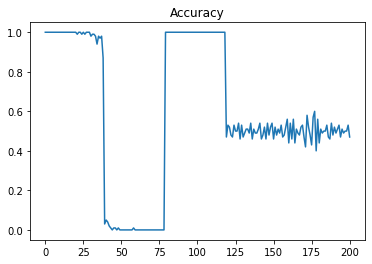

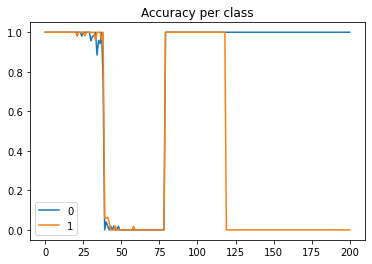

In [28]:
fc, accuracies, accuracies_per_class = train_fast_compose(streaming_data_3d, streaming_labels_3d, training_set_size=1500, print_interval=25, print_label_counts_in_clusters=True)

Number of clusters = 4


53it [00:02, 16.01it/s]

Number of clusters = 4
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


55it [00:02, 11.55it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


57it [00:03,  9.01it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


60it [00:03,  7.52it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


62it [00:04,  7.12it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


64it [00:04,  6.88it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


65it [00:04,  6.94it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


67it [00:04,  6.49it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


69it [00:05,  6.54it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


71it [00:05,  6.58it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4

72it [00:05,  6.53it/s]


Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


74it [00:05,  6.46it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


76it [00:06,  6.29it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


77it [00:06,  6.22it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


79it [00:06,  6.09it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


81it [00:07,  6.59it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


83it [00:07,  6.93it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


84it [00:07,  7.04it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


86it [00:07,  7.28it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


88it [00:07,  7.24it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


90it [00:08,  7.23it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


93it [00:08,  7.46it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


94it [00:08,  7.02it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


96it [00:09,  6.55it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


98it [00:09,  6.24it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


99it [00:09,  6.14it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


101it [00:09,  6.13it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


102it [00:10,  6.09it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


104it [00:10,  6.09it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


105it [00:10,  6.09it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


107it [00:10,  6.13it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


108it [00:11,  5.92it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


110it [00:11,  5.99it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4

111it [00:11,  6.00it/s]


Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


113it [00:11,  6.12it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


114it [00:12,  6.14it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


116it [00:12,  6.30it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4

117it [00:12,  6.26it/s]


Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


119it [00:12,  6.19it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


120it [00:13,  6.21it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


122it [00:13,  5.97it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


123it [00:13,  5.90it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


125it [00:13,  6.04it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


126it [00:14,  6.07it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


128it [00:14,  6.14it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


130it [00:14,  6.12it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


131it [00:14,  6.14it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


133it [00:15,  6.18it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


134it [00:15,  5.98it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3


136it [00:15,  5.92it/s]

Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1


137it [00:15,  5.85it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3


138it [00:16,  5.66it/s]

Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1


140it [00:16,  5.64it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4


141it [00:16,  5.63it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


143it [00:16,  5.62it/s]

Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1


144it [00:17,  5.62it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3


146it [00:17,  5.63it/s]

Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1


147it [00:17,  5.55it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4


148it [00:17,  5.53it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


150it [00:18,  5.26it/s]

Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4

151it [00:18,  5.34it/s]


Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3


152it [00:18,  5.49it/s]

Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1


154it [00:19,  5.57it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4


155it [00:19,  5.57it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


157it [00:19,  5.56it/s]

Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1


158it [00:19,  5.59it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3


160it [00:20,  6.16it/s]

Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4


162it [00:20,  6.79it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4


164it [00:20,  7.04it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


166it [00:20,  7.38it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


168it [00:21,  7.42it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4


170it [00:21,  7.54it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


172it [00:21,  7.45it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


173it [00:21,  7.37it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


175it [00:22,  6.71it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


176it [00:22,  6.59it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


178it [00:22,  6.05it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


179it [00:22,  6.01it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


180it [00:22,  6.01it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


182it [00:23,  6.09it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


183it [00:23,  6.06it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


185it [00:23,  6.11it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


187it [00:24,  6.13it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


188it [00:24,  6.09it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


190it [00:24,  6.13it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4

191it [00:24,  6.14it/s]


Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


193it [00:25,  6.05it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


195it [00:25,  6.07it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


196it [00:25,  6.09it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


198it [00:25,  6.07it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


200it [00:26,  6.09it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4

201it [00:26,  7.62it/s]



Number of clusters = 3
Number of clusters = 2
Time elapsed: 26.390413999557495


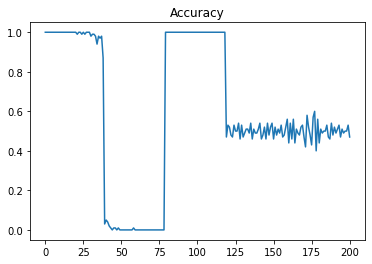

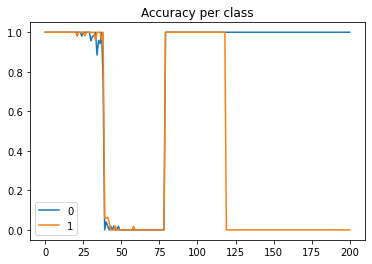

54it [00:03, 13.06it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


56it [00:03,  9.96it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


58it [00:03,  8.31it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


60it [00:03,  7.52it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


62it [00:04,  7.14it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


63it [00:04,  7.12it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


65it [00:04,  6.99it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


67it [00:05,  6.76it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


69it [00:05,  6.72it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


71it [00:05,  6.63it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4

72it [00:05,  6.55it/s]


Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


74it [00:06,  6.23it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


75it [00:06,  6.05it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


77it [00:06,  6.12it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


78it [00:06,  6.13it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


80it [00:07,  6.40it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


82it [00:07,  6.78it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


84it [00:07,  6.93it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


86it [00:07,  6.94it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


88it [00:08,  6.68it/s]

Number of clusters = 4
Number of clusters = 3


90it [00:08,  6.32it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


92it [00:08,  6.70it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


93it [00:09,  6.78it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


95it [00:09,  6.43it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


96it [00:09,  6.42it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


98it [00:09,  6.36it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4

99it [00:09,  6.38it/s]


Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


101it [00:10,  6.41it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


103it [00:10,  6.38it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4

104it [00:10,  6.38it/s]


Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


106it [00:11,  6.31it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


108it [00:11,  6.38it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4

109it [00:11,  6.32it/s]


Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


111it [00:11,  6.26it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


113it [00:12,  6.27it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4

114it [00:12,  6.26it/s]


Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


116it [00:12,  6.29it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


118it [00:12,  6.24it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


119it [00:13,  6.19it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


121it [00:13,  6.20it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


122it [00:13,  6.19it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


124it [00:13,  6.29it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


125it [00:14,  6.32it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


127it [00:14,  6.15it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


128it [00:14,  6.10it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


129it [00:14,  6.04it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


131it [00:15,  6.08it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


133it [00:15,  6.20it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


134it [00:15,  6.05it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4


135it [00:15,  5.85it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3


137it [00:16,  5.69it/s]

Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1


138it [00:16,  5.68it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4


139it [00:16,  5.57it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3


140it [00:16,  5.54it/s]

Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


142it [00:17,  5.38it/s]

Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1


143it [00:17,  5.47it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3


144it [00:17,  5.45it/s]

Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


146it [00:17,  5.58it/s]

Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1


147it [00:17,  5.58it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4


148it [00:18,  5.60it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1


150it [00:18,  5.58it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4


151it [00:18,  5.59it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1


153it [00:19,  5.59it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4


154it [00:19,  5.59it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


156it [00:19,  5.62it/s]

Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1


157it [00:19,  5.61it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3


159it [00:20,  5.66it/s]

Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1


161it [00:20,  6.47it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


163it [00:20,  6.87it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


165it [00:20,  7.14it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


167it [00:21,  7.14it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


168it [00:21,  7.15it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


170it [00:21,  7.05it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


172it [00:21,  7.08it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


174it [00:22,  6.66it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


175it [00:22,  6.43it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


177it [00:22,  6.28it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


179it [00:23,  6.36it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


180it [00:23,  6.39it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


182it [00:23,  6.42it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


184it [00:23,  6.50it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


185it [00:23,  6.46it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


187it [00:24,  6.32it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


189it [00:24,  6.15it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


190it [00:24,  6.12it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


192it [00:25,  6.05it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


193it [00:25,  6.06it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


194it [00:25,  6.00it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


196it [00:25,  6.08it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


198it [00:26,  6.13it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


199it [00:26,  6.15it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


201it [00:26,  7.57it/s]


Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Time elapsed: 26.562613010406494


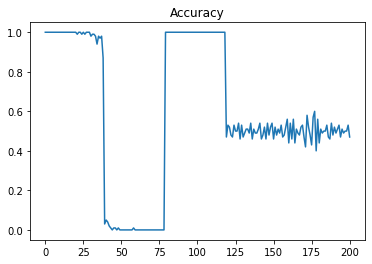

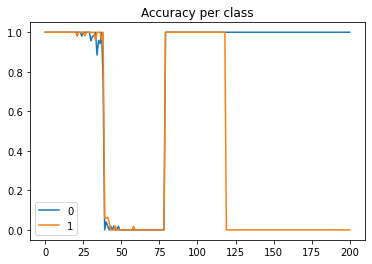

54it [00:03, 13.03it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


56it [00:03, 10.18it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


58it [00:03,  8.42it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


60it [00:04,  7.44it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


62it [00:04,  7.08it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


64it [00:04,  6.81it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


65it [00:04,  6.88it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


67it [00:05,  6.46it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


69it [00:05,  6.46it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


70it [00:05,  6.62it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


72it [00:05,  6.40it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


73it [00:06,  6.22it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


75it [00:06,  6.27it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


77it [00:06,  6.16it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


78it [00:06,  6.11it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


80it [00:07,  6.36it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4


82it [00:07,  6.71it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


83it [00:07,  6.83it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


85it [00:07,  7.00it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


87it [00:08,  7.06it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


89it [00:08,  7.04it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


91it [00:08,  7.13it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


93it [00:08,  7.18it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


95it [00:09,  6.52it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


96it [00:09,  6.43it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


98it [00:09,  6.44it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


100it [00:10,  6.21it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


101it [00:10,  6.13it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


103it [00:10,  6.16it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


104it [00:10,  6.09it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


106it [00:11,  5.90it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


107it [00:11,  5.93it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


109it [00:11,  5.91it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


110it [00:11,  5.90it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


112it [00:12,  6.05it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4

113it [00:12,  6.13it/s]


Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


115it [00:12,  5.96it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


116it [00:12,  6.01it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


118it [00:13,  6.14it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


120it [00:13,  6.02it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


121it [00:13,  6.03it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


123it [00:13,  6.06it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


124it [00:14,  5.96it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


126it [00:14,  5.97it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


127it [00:14,  6.04it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


129it [00:14,  5.98it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


130it [00:15,  5.95it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


132it [00:15,  6.08it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


133it [00:15,  6.12it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


134it [00:15,  5.88it/s]

Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


136it [00:16,  5.67it/s]

Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1


137it [00:16,  5.70it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4


138it [00:16,  5.58it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


140it [00:16,  5.67it/s]

Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1


141it [00:17,  5.59it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3


142it [00:17,  5.51it/s]

Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


144it [00:17,  5.56it/s]

Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1


145it [00:17,  5.62it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3


147it [00:18,  5.54it/s]

Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1


148it [00:18,  5.50it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4


149it [00:18,  5.50it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


151it [00:18,  5.53it/s]

Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1


152it [00:19,  5.52it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3


153it [00:19,  5.49it/s]

Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


155it [00:19,  5.49it/s]

Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1


156it [00:19,  5.48it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3


157it [00:19,  5.45it/s]

Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


159it [00:20,  5.46it/s]

Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1


160it [00:20,  5.91it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


163it [00:20,  6.94it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


164it [00:21,  7.07it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


167it [00:21,  7.34it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4

169it [00:21,  7.44it/s]


Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


170it [00:21,  7.41it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


172it [00:22,  6.71it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


174it [00:22,  6.57it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


175it [00:22,  6.27it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


177it [00:22,  6.20it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


178it [00:23,  5.99it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


180it [00:23,  6.02it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4

181it [00:23,  6.07it/s]


Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


183it [00:23,  6.07it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


184it [00:24,  6.06it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


186it [00:24,  6.04it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


187it [00:24,  6.00it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


189it [00:24,  6.03it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


190it [00:25,  6.06it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


192it [00:25,  5.81it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


193it [00:25,  5.30it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


195it [00:26,  5.71it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


196it [00:26,  5.79it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


198it [00:26,  5.90it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


199it [00:26,  5.96it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


201it [00:27,  7.44it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Time elapsed: 27.026851892471313


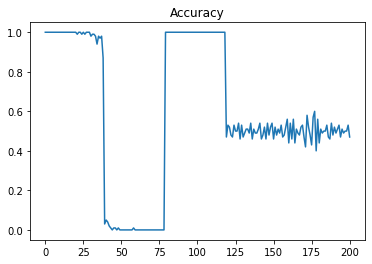

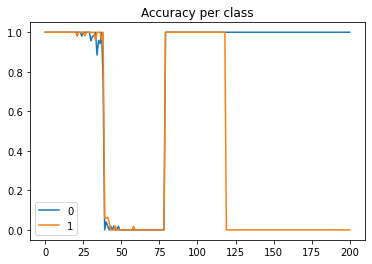

54it [00:02, 13.65it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


56it [00:03, 10.34it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


58it [00:03,  8.57it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


61it [00:04,  7.64it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


62it [00:04,  7.19it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


64it [00:04,  6.93it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


66it [00:04,  6.73it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


68it [00:05,  6.80it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


69it [00:05,  6.55it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


71it [00:05,  6.45it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


73it [00:05,  6.27it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


74it [00:06,  6.18it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


76it [00:06,  6.15it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


77it [00:06,  6.17it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


79it [00:06,  6.06it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


80it [00:07,  6.32it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


82it [00:07,  6.77it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


84it [00:07,  7.07it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


86it [00:07,  7.16it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


88it [00:08,  7.14it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


90it [00:08,  7.13it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


92it [00:08,  7.12it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


94it [00:09,  6.71it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


96it [00:09,  6.30it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


97it [00:09,  6.23it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


99it [00:09,  6.13it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


101it [00:10,  6.03it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


102it [00:10,  6.02it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


104it [00:10,  6.01it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


105it [00:10,  5.98it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


106it [00:11,  5.32it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


107it [00:11,  5.53it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


109it [00:11,  5.69it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


110it [00:11,  5.09it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


111it [00:12,  5.32it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


113it [00:12,  4.68it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


114it [00:12,  4.98it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


116it [00:12,  5.50it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


117it [00:13,  5.70it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


119it [00:13,  5.95it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4

120it [00:13,  5.99it/s]


Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


122it [00:13,  6.02it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


123it [00:14,  6.04it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


125it [00:14,  6.06it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


126it [00:14,  6.15it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


128it [00:14,  6.17it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


129it [00:15,  6.18it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


131it [00:15,  6.18it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


133it [00:15,  6.19it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


134it [00:15,  6.05it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4


135it [00:16,  5.97it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1


137it [00:16,  5.76it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4


138it [00:16,  5.78it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1


140it [00:16,  5.72it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4


141it [00:17,  5.65it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3


143it [00:17,  5.53it/s]

Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1


144it [00:17,  4.95it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1


145it [00:17,  4.92it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4


146it [00:18,  4.91it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4


147it [00:18,  4.86it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3


148it [00:18,  5.02it/s]

Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


150it [00:18,  5.23it/s]

Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1


151it [00:19,  4.88it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1


152it [00:19,  4.70it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1


153it [00:19,  4.71it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4


154it [00:19,  4.83it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4


155it [00:20,  4.79it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3


157it [00:20,  5.15it/s]

Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1


158it [00:20,  5.19it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4


160it [00:20,  5.85it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4


162it [00:21,  6.60it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


163it [00:21,  6.77it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


165it [00:21,  6.32it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


167it [00:21,  6.48it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


169it [00:22,  6.63it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


171it [00:22,  6.83it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4


173it [00:22,  6.81it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4


174it [00:22,  6.53it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


176it [00:23,  6.23it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


178it [00:23,  6.25it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


179it [00:23,  6.02it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


181it [00:24,  5.97it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


182it [00:24,  5.83it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


183it [00:24,  5.80it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


185it [00:24,  5.78it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


186it [00:25,  5.82it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


187it [00:25,  5.83it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


189it [00:25,  5.86it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


190it [00:25,  5.81it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


191it [00:25,  5.63it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


193it [00:26,  5.83it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


194it [00:26,  5.89it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


195it [00:26,  5.87it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


197it [00:26,  5.66it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


199it [00:27,  5.87it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


200it [00:27,  5.96it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


201it [00:27,  7.29it/s]


Number of clusters = 3
Number of clusters = 2
Time elapsed: 27.58946204185486


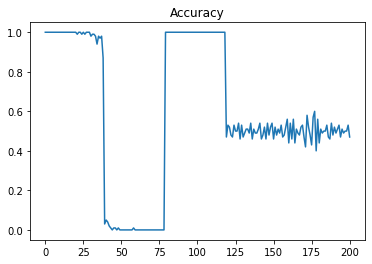

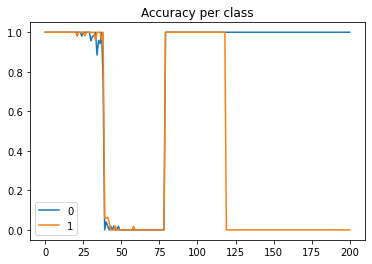

54it [00:02, 13.79it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


56it [00:03, 10.57it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


58it [00:03,  8.67it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


61it [00:03,  7.65it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


63it [00:04,  7.35it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


64it [00:04,  7.00it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


66it [00:04,  6.70it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


67it [00:04,  6.50it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


69it [00:05,  6.08it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


71it [00:05,  6.30it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


72it [00:05,  6.30it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


74it [00:05,  6.35it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


75it [00:06,  6.27it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


77it [00:06,  6.32it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


79it [00:06,  6.42it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


81it [00:07,  7.00it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


83it [00:07,  7.21it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4


85it [00:07,  7.34it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4

87it [00:07,  7.50it/s]


Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


89it [00:08,  7.56it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


90it [00:08,  7.42it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


92it [00:08,  7.52it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


94it [00:08,  7.17it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


96it [00:09,  6.69it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


97it [00:09,  6.62it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


99it [00:09,  6.41it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


101it [00:09,  6.40it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


102it [00:10,  6.38it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


104it [00:10,  6.24it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


105it [00:10,  6.00it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


107it [00:10,  6.02it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


108it [00:11,  5.87it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


110it [00:11,  5.81it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


111it [00:11,  5.81it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


113it [00:11,  5.91it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


114it [00:12,  5.68it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


116it [00:12,  5.85it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


117it [00:12,  5.91it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


118it [00:12,  5.92it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


120it [00:13,  5.85it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


121it [00:13,  5.53it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


123it [00:13,  5.76it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


124it [00:13,  5.88it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


126it [00:14,  5.88it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


128it [00:14,  5.96it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


129it [00:14,  5.93it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


131it [00:14,  6.00it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


132it [00:15,  5.83it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


133it [00:15,  5.87it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


135it [00:15,  5.59it/s]

Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1


136it [00:15,  5.54it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4


137it [00:16,  5.41it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3


138it [00:16,  5.35it/s]

Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


140it [00:16,  5.32it/s]

Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1


141it [00:16,  5.33it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4


142it [00:17,  5.37it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3


143it [00:17,  5.38it/s]

Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


144it [00:17,  5.19it/s]

Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


145it [00:17,  5.01it/s]

Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1


147it [00:18,  5.14it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1


148it [00:18,  5.05it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4


149it [00:18,  5.07it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3


150it [00:18,  5.10it/s]

Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


152it [00:19,  5.19it/s]

Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1


153it [00:19,  5.28it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4


154it [00:19,  5.23it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3


155it [00:19,  5.28it/s]

Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1


157it [00:19,  5.15it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4


158it [00:20,  5.18it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4


160it [00:20,  5.45it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 1
Number of clusters = 4
Number of clusters = 3


162it [00:20,  6.39it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


164it [00:21,  6.71it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


166it [00:21,  7.06it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


168it [00:21,  7.21it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


170it [00:21,  7.43it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


172it [00:22,  7.36it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4

173it [00:22,  7.40it/s]


Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


175it [00:22,  6.59it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


177it [00:22,  6.32it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


178it [00:23,  6.16it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


179it [00:23,  5.66it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


181it [00:23,  5.73it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4

182it [00:23,  5.81it/s]


Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


184it [00:24,  5.89it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


185it [00:24,  5.86it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


186it [00:24,  5.85it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


188it [00:24,  5.93it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


189it [00:25,  5.64it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


190it [00:25,  5.44it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


191it [00:25,  5.54it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


193it [00:25,  5.67it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


194it [00:25,  5.69it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


196it [00:26,  5.57it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


197it [00:26,  5.64it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


198it [00:26,  5.47it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


200it [00:27,  5.90it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


201it [00:27,  7.39it/s]


Number of clusters = 3
Number of clusters = 2
Time elapsed: 27.197507858276367


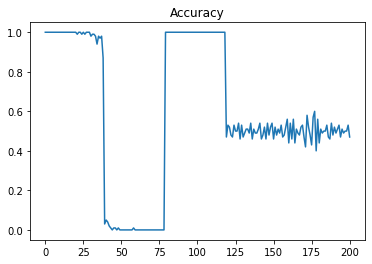

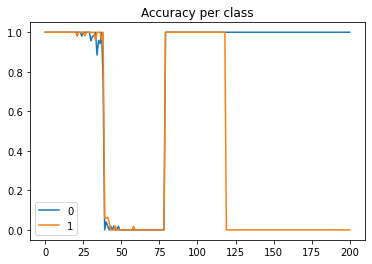

In [29]:
# Obtain averaged results
accuracy_results = []
accuracy_per_class_results = []
for i in range(5):
    fc, accuracies, accuracies_per_class = train_fast_compose(streaming_data_3d, streaming_labels_3d, training_set_size=1500, print_interval=1000, print_label_counts_in_clusters=False)
    accuracy_results.append(accuracies)
    accuracy_per_class_results.append(accuracies_per_class)

Text(0.5, 1.0, 'Accuracy averaged over 5 learning trials')

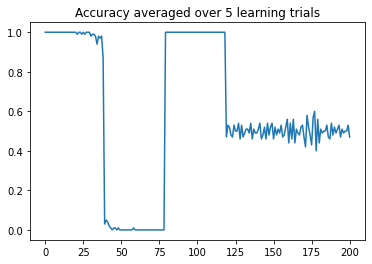

In [30]:
plt.plot(np.array(accuracy_results).mean(axis=0))
plt.title("Accuracy averaged over 5 learning trials")

In [31]:
avg_results_per_class = []
for class_ in range(2):
    result_per_class = np.array([dict_[class_] for dict_ in accuracy_per_class_results if class_ in dict_.keys()], dtype=float)
    avg_result_per_class = np.nanmean(result_per_class, axis=0)
    avg_results_per_class.append(avg_result_per_class)

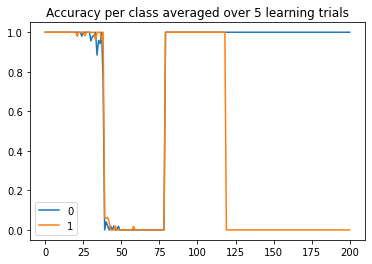

In [32]:
for class_ in range(2):
    plt.plot(avg_results_per_class[class_], label=class_)
    plt.legend()
    plt.title("Accuracy per class averaged over 5 learning trials")

# Experiments 3D with added class

In [33]:
dataset_3d = "./3d_gaussian_data_added_class.csv"
gaussian_data_3d = pd.read_csv(dataset_3d)
y_3d = gaussian_data_3d.pop('label').to_numpy()
X_3d = gaussian_data_3d.to_numpy()

In [34]:
X_3d.shape

(30300, 3)

In [35]:
y_3d.shape

(30300,)

In [36]:
for xi, yi in stream.iter_array(X_3d, y_3d):
    print(xi, yi)
    break

{0: -1.0151555241479664, 1: -1.4161182780401813, 2: 1.951098984742738} 1


In [37]:
streaming_data_3d = np.split(X_3d, X_3d.shape[0]/100)
streaming_labels_3d = np.split(y_3d, y_3d.shape[0]/100)

In [38]:
streaming_data_3d[0].shape

(100, 3)

In [39]:
streaming_labels_3d[0].shape

(100,)

Number of clusters = 4
Number of clusters = 3


22it [00:00, 20.71it/s]

{0: 509, 2: 5, 1: 2}
{2: 483, 1: 2}
{1: 130}
{1: 295, 2: 4}
{1: 61, 2: 9}


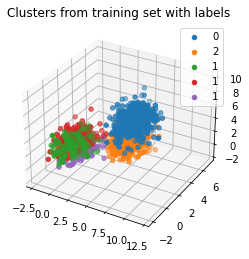

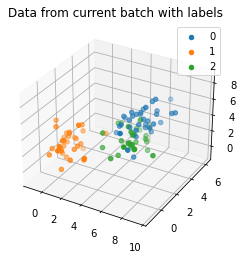

49it [00:02, 16.99it/s]

{0: 227, 1: 1}
{2: 107, 1: 31}
{1: 376, 2: 4, 0: 1}
{2: 398, 1: 79, 0: 1}
{0: 258, 2: 10, 1: 7}


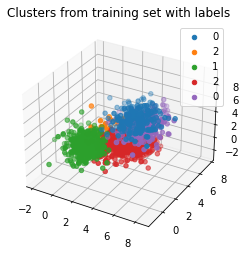

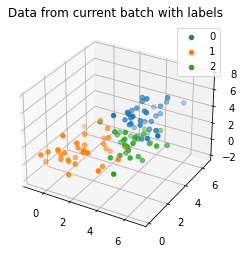

73it [00:04, 17.44it/s]

Number of clusters = 4
{0: 495, 2: 7}
{2: 427, 0: 4, 1: 2}
{0: 8, 2: 68, 1: 42}
{0: 72, 1: 369, 2: 6}


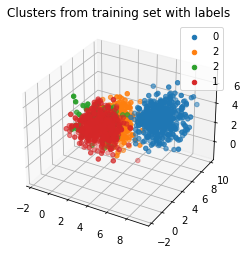

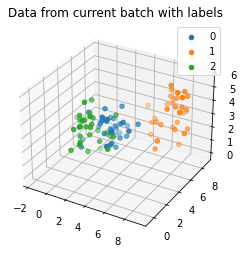

99it [00:06, 17.29it/s]

{0: 505}
{2: 504}
{1: 89}
{1: 83}
{2: 2, 1: 317}


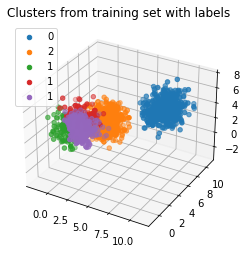

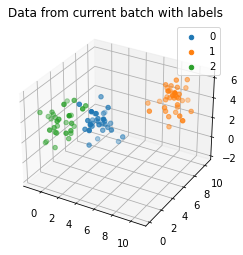

123it [00:08, 16.65it/s]

{0: 489, 2: 138}
{2: 221, 1: 17}
{1: 98}
{1: 202, 2: 133}
{0: 8, 1: 194}


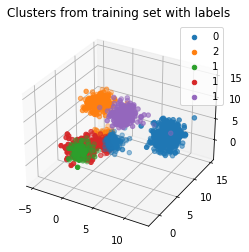

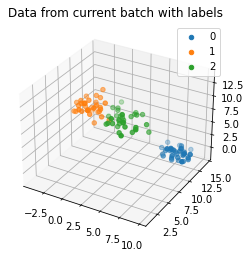

133it [00:09, 13.46it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


135it [00:09, 10.74it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


137it [00:09,  9.43it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


140it [00:10,  8.23it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


142it [00:10,  7.82it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


144it [00:10,  7.50it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


146it [00:10,  7.46it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


148it [00:11,  7.32it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


149it [00:11,  7.30it/s]

Number of clusters = 4
Number of clusters = 3
{1: 500}
{0: 491}
{2: 509}


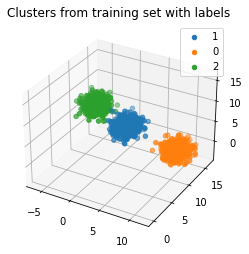

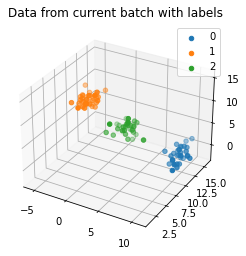

151it [00:12,  4.81it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


153it [00:12,  5.85it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


155it [00:12,  6.35it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4


157it [00:12,  6.49it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


159it [00:13,  6.84it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


161it [00:13,  7.08it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4

163it [00:13,  7.16it/s]


Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


164it [00:13,  6.83it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


166it [00:14,  7.05it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


168it [00:14,  7.27it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


170it [00:14,  7.28it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


172it [00:14,  7.33it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


174it [00:15,  7.28it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
{1: 494}
{0: 503}
{2: 503}


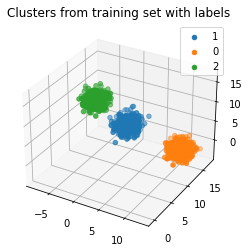

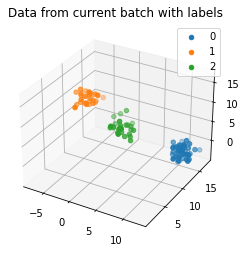

176it [00:15,  5.00it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


178it [00:16,  5.92it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


180it [00:16,  6.42it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


182it [00:16,  6.58it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4


184it [00:16,  6.89it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4


186it [00:17,  7.18it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4

188it [00:17,  7.23it/s]


Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


189it [00:17,  7.21it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


191it [00:17,  7.24it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


193it [00:18,  7.33it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


195it [00:18,  6.79it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


196it [00:18,  6.53it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


198it [00:18,  6.48it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


199it [00:19,  6.46it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
{0: 1000}
{1: 500}


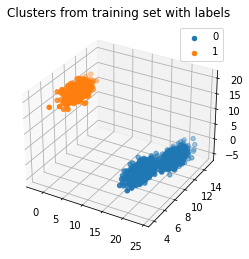

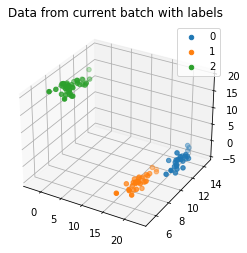

201it [00:19,  4.24it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


203it [00:20,  4.96it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


204it [00:20,  5.03it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


205it [00:20,  5.19it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


207it [00:20,  5.60it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


209it [00:21,  5.99it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4

210it [00:21,  6.07it/s]


Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


212it [00:21,  6.16it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


214it [00:21,  6.19it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


215it [00:22,  6.18it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


217it [00:22,  6.34it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4

218it [00:22,  6.35it/s]


Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


220it [00:22,  6.23it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


222it [00:23,  6.25it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


223it [00:23,  6.16it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


224it [00:23,  6.08it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
{1: 505}
{0: 995}


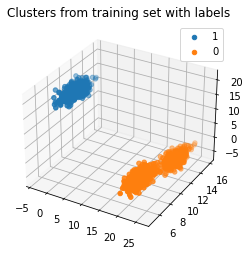

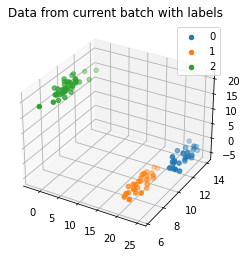

226it [00:24,  4.15it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


227it [00:24,  4.57it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


229it [00:24,  5.19it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


230it [00:24,  5.37it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


232it [00:25,  5.67it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


233it [00:25,  5.71it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


234it [00:25,  5.74it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


236it [00:25,  5.87it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


237it [00:26,  5.81it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


238it [00:26,  5.84it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


240it [00:26,  6.63it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 4


243it [00:26,  7.94it/s]

Number of clusters = 4
Number of clusters = 4


245it [00:27,  8.05it/s]

Number of clusters = 4
Number of clusters = 4


247it [00:27,  8.16it/s]

Number of clusters = 4
Number of clusters = 4


249it [00:27,  8.20it/s]

Number of clusters = 4
Number of clusters = 4
Number of clusters = 4
{0: 272}
{1: 442}
{1: 363, 0: 1}
{1: 422}


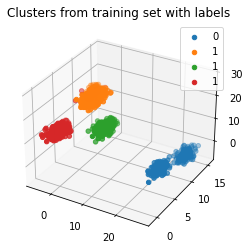

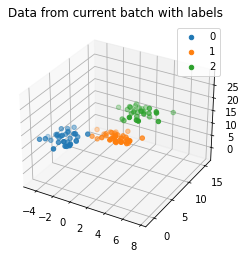

252it [00:28,  5.66it/s]

Number of clusters = 4
Number of clusters = 4


253it [00:28,  6.20it/s]

Number of clusters = 4
Number of clusters = 4
Number of clusters = 3


255it [00:28,  5.88it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4


257it [00:29,  6.22it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


258it [00:29,  6.32it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


260it [00:29,  6.45it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


262it [00:29,  6.55it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


264it [00:30,  6.46it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4


266it [00:30,  6.40it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


267it [00:30,  6.46it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4


269it [00:31,  6.39it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


271it [00:31,  6.53it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


272it [00:31,  6.58it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


274it [00:31,  6.54it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
{1: 500}
{1: 500}
{1: 500}


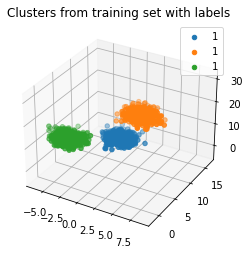

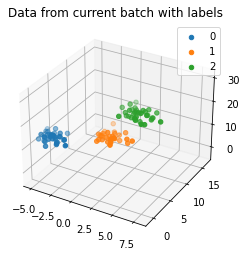

276it [00:32,  3.76it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4


278it [00:32,  4.74it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


279it [00:33,  5.16it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


281it [00:33,  5.84it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


283it [00:33,  6.57it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


286it [00:34,  7.26it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


287it [00:34,  7.32it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


289it [00:34,  7.26it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


291it [00:34,  7.35it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


293it [00:34,  7.41it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


295it [00:35,  7.52it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


297it [00:35,  7.34it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


299it [00:35,  7.36it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
{1: 500}
{1: 498}
{1: 502}


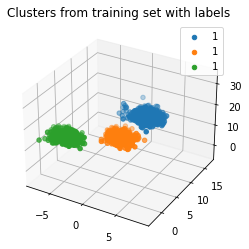

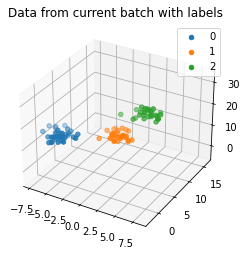

301it [00:36,  5.04it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


302it [00:36,  8.27it/s]


Time elapsed: 36.50826716423035


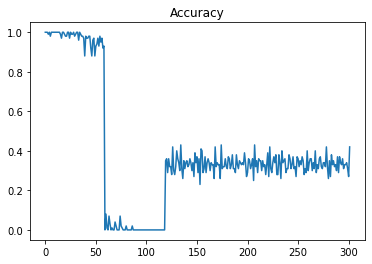

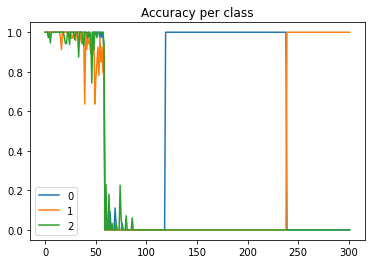

In [40]:
fc, accuracies, accuracies_per_class = train_fast_compose(streaming_data_3d, streaming_labels_3d, training_set_size=1500, print_interval=25, print_label_counts_in_clusters=True)

Number of clusters = 4
Number of clusters = 3


76it [00:04, 15.61it/s]

Number of clusters = 4


134it [00:07, 15.04it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


136it [00:07, 11.77it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


138it [00:07, 10.01it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


140it [00:08,  8.54it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


142it [00:08,  7.88it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


144it [00:08,  7.60it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


146it [00:09,  7.05it/s]

Number of clusters = 4
Number of clusters = 3


147it [00:09,  6.27it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


149it [00:09,  6.66it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


151it [00:09,  6.98it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


153it [00:10,  7.14it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


155it [00:10,  7.25it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


157it [00:10,  7.28it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


159it [00:11,  7.44it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


161it [00:11,  7.41it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


163it [00:11,  7.51it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


165it [00:11,  7.32it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


167it [00:12,  7.20it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


169it [00:12,  7.18it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


171it [00:12,  7.18it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


173it [00:12,  7.17it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


175it [00:13,  7.23it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


177it [00:13,  7.18it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


179it [00:13,  7.16it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


181it [00:14,  7.11it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


183it [00:14,  7.28it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


185it [00:14,  7.36it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


187it [00:14,  7.22it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


189it [00:15,  7.16it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


191it [00:15,  7.03it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


193it [00:15,  7.17it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


195it [00:16,  6.53it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


196it [00:16,  6.34it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


198it [00:16,  6.25it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


199it [00:16,  6.24it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


201it [00:17,  6.12it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


202it [00:17,  6.09it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


204it [00:17,  6.10it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


206it [00:17,  6.11it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


207it [00:18,  6.07it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


209it [00:18,  5.84it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


210it [00:18,  5.91it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


212it [00:18,  6.06it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


214it [00:19,  6.20it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4

215it [00:19,  6.29it/s]


Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


217it [00:19,  6.35it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


219it [00:20,  6.29it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4

220it [00:20,  6.31it/s]


Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


222it [00:20,  6.41it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


224it [00:20,  6.46it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4

225it [00:20,  6.37it/s]


Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


227it [00:21,  6.38it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


229it [00:21,  6.42it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


230it [00:21,  6.41it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


232it [00:22,  6.25it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4

233it [00:22,  6.30it/s]


Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


235it [00:22,  6.38it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


237it [00:22,  6.48it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


239it [00:23,  6.52it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


241it [00:23,  7.79it/s]

Number of clusters = 4
Number of clusters = 4
Number of clusters = 4


243it [00:23,  8.67it/s]

Number of clusters = 4
Number of clusters = 4
Number of clusters = 4


247it [00:23,  9.63it/s]

Number of clusters = 4
Number of clusters = 4
Number of clusters = 4


250it [00:24,  9.64it/s]

Number of clusters = 4
Number of clusters = 4
Number of clusters = 4


252it [00:24,  9.79it/s]

Number of clusters = 4
Number of clusters = 4
Number of clusters = 4


255it [00:24,  9.11it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


256it [00:24,  8.40it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


259it [00:25,  8.03it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


261it [00:25,  7.89it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


263it [00:25,  7.66it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


265it [00:26,  7.66it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


267it [00:26,  7.72it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4

269it [00:26,  7.58it/s]


Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4

271it [00:26,  7.49it/s]


Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4

273it [00:27,  7.65it/s]


Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


275it [00:27,  7.68it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4

277it [00:27,  7.77it/s]


Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4


279it [00:27,  7.76it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4


281it [00:28,  7.70it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4

283it [00:28,  7.66it/s]


Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


285it [00:28,  7.73it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


286it [00:28,  7.73it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


288it [00:29,  7.47it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


290it [00:29,  7.37it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


292it [00:29,  7.36it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


294it [00:29,  7.45it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


296it [00:30,  7.46it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


298it [00:30,  7.46it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


300it [00:30,  7.36it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


302it [00:30,  9.75it/s]


Number of clusters = 4
Number of clusters = 3
Time elapsed: 30.99667191505432


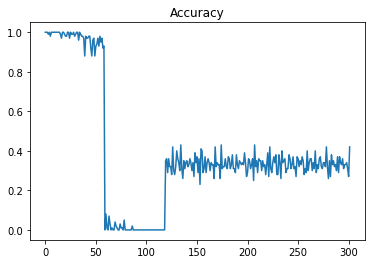

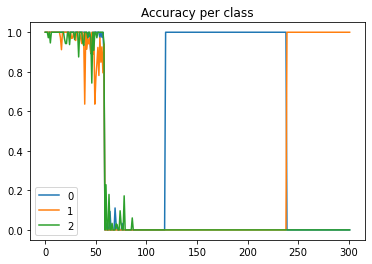

Number of clusters = 4
Number of clusters = 3


77it [00:04, 17.01it/s]

Number of clusters = 4


135it [00:07, 12.98it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


137it [00:07, 10.86it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


139it [00:07,  9.76it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


141it [00:08,  9.10it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4


143it [00:08,  8.49it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


145it [00:08,  7.99it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


146it [00:08,  7.80it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


149it [00:09,  7.73it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


151it [00:09,  7.57it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


153it [00:09,  7.47it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4

155it [00:10,  7.65it/s]


Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4

157it [00:10,  7.65it/s]


Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


159it [00:10,  7.72it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


161it [00:10,  7.56it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4

163it [00:11,  7.55it/s]


Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


165it [00:11,  7.63it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4

167it [00:11,  7.60it/s]


Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


169it [00:11,  7.68it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4


171it [00:12,  7.68it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4


173it [00:12,  7.71it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4


175it [00:12,  7.49it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


177it [00:12,  7.58it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


179it [00:13,  7.47it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


181it [00:13,  7.53it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


183it [00:13,  7.58it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


185it [00:13,  7.49it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4


187it [00:14,  7.45it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


189it [00:14,  7.67it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4


191it [00:14,  7.70it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4


193it [00:15,  7.74it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4


195it [00:15,  7.08it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


196it [00:15,  6.82it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


198it [00:15,  6.59it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


200it [00:16,  6.45it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


201it [00:16,  6.42it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


203it [00:16,  6.53it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


204it [00:16,  6.51it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


206it [00:17,  6.49it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


208it [00:17,  6.50it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


209it [00:17,  6.46it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


211it [00:17,  6.39it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


213it [00:18,  6.34it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4

214it [00:18,  6.31it/s]


Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


216it [00:18,  6.29it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


218it [00:18,  6.26it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


219it [00:19,  6.12it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


221it [00:19,  6.23it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


222it [00:19,  6.26it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


224it [00:19,  6.28it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


225it [00:20,  6.24it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


227it [00:20,  6.14it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


228it [00:20,  6.07it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


230it [00:20,  6.12it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


231it [00:21,  6.17it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


233it [00:21,  6.23it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


235it [00:21,  6.32it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4

236it [00:21,  6.32it/s]


Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


238it [00:22,  6.28it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


241it [00:22,  7.62it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 4


242it [00:22,  8.05it/s]

Number of clusters = 4
Number of clusters = 4
Number of clusters = 4


246it [00:22,  9.33it/s]

Number of clusters = 4
Number of clusters = 4
Number of clusters = 4


249it [00:23,  9.60it/s]

Number of clusters = 4
Number of clusters = 4
Number of clusters = 4


252it [00:23,  9.69it/s]

Number of clusters = 4
Number of clusters = 4


254it [00:23,  8.80it/s]

Number of clusters = 4
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4


256it [00:24,  8.01it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


257it [00:24,  7.85it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


259it [00:24,  7.69it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


261it [00:24,  7.53it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


263it [00:25,  7.49it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


265it [00:25,  7.32it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


267it [00:25,  7.30it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


269it [00:25,  7.30it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


271it [00:26,  7.23it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


273it [00:26,  7.33it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


275it [00:26,  7.29it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


277it [00:26,  7.53it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


279it [00:27,  7.61it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


281it [00:27,  7.55it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


283it [00:27,  7.16it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


285it [00:28,  7.18it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


287it [00:28,  7.33it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


289it [00:28,  7.39it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


291it [00:28,  7.24it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


293it [00:29,  7.35it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


296it [00:29,  7.58it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


298it [00:29,  7.61it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4


300it [00:30,  7.20it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


302it [00:30,  7.43it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


302it [00:30,  9.95it/s]


Time elapsed: 30.370369911193848


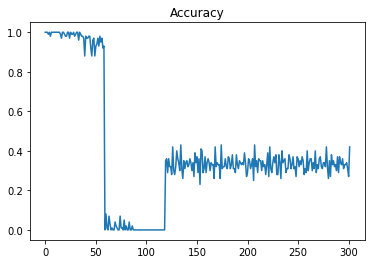

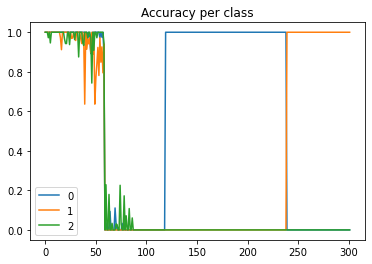

Number of clusters = 4
Number of clusters = 3


77it [00:04, 16.22it/s]

Number of clusters = 4


133it [00:07, 16.87it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


135it [00:07, 11.90it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


137it [00:07,  9.60it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


139it [00:08,  8.70it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4


142it [00:08,  7.63it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


143it [00:08,  7.52it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


145it [00:08,  7.34it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


147it [00:09,  7.12it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


149it [00:09,  7.11it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


151it [00:09,  7.04it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


153it [00:10,  6.93it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


155it [00:10,  6.99it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


157it [00:10,  7.15it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


159it [00:10,  7.36it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


161it [00:11,  7.45it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


163it [00:11,  7.28it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


165it [00:11,  7.40it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


167it [00:12,  7.52it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


169it [00:12,  7.28it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


171it [00:12,  7.30it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4


173it [00:12,  7.09it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


174it [00:13,  7.18it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


176it [00:13,  7.27it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


178it [00:13,  7.39it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


180it [00:13,  7.29it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


182it [00:14,  7.16it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


184it [00:14,  7.20it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


186it [00:14,  7.22it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


188it [00:14,  7.39it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


190it [00:15,  7.38it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


192it [00:15,  7.42it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


194it [00:15,  7.02it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


196it [00:16,  6.62it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


197it [00:16,  6.48it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


199it [00:16,  6.46it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


200it [00:16,  6.44it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


201it [00:16,  5.79it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


203it [00:17,  6.10it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


205it [00:17,  6.08it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


206it [00:17,  6.10it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


208it [00:18,  6.18it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


210it [00:18,  6.16it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


211it [00:18,  6.30it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


213it [00:18,  6.35it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


214it [00:18,  6.41it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


216it [00:19,  6.30it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


217it [00:19,  6.29it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


219it [00:19,  6.33it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


221it [00:20,  6.32it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


222it [00:20,  6.28it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


224it [00:20,  6.14it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


225it [00:20,  6.18it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


227it [00:21,  6.29it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


228it [00:21,  6.25it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


230it [00:21,  6.27it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


231it [00:21,  6.28it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


233it [00:22,  6.30it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


235it [00:22,  6.41it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


236it [00:22,  6.43it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


238it [00:22,  6.41it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


239it [00:22,  6.28it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 4


243it [00:23,  8.47it/s]

Number of clusters = 4
Number of clusters = 4
Number of clusters = 4


246it [00:23,  9.30it/s]

Number of clusters = 4
Number of clusters = 4
Number of clusters = 4


248it [00:23,  9.48it/s]

Number of clusters = 4
Number of clusters = 4
Number of clusters = 4


252it [00:24, 10.02it/s]

Number of clusters = 4
Number of clusters = 4
Number of clusters = 4


254it [00:24,  8.90it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


256it [00:24,  8.14it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


258it [00:25,  7.86it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


260it [00:25,  7.70it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


262it [00:25,  7.59it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


264it [00:25,  7.51it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


266it [00:26,  7.53it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


268it [00:26,  7.47it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


270it [00:26,  7.35it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


273it [00:27,  7.48it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


275it [00:27,  7.61it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


277it [00:27,  7.64it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4

279it [00:27,  7.61it/s]


Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4


281it [00:28,  7.62it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


283it [00:28,  7.55it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


285it [00:28,  7.38it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


287it [00:28,  7.36it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


288it [00:29,  7.33it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


290it [00:29,  7.31it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


292it [00:29,  7.34it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


294it [00:29,  7.35it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


296it [00:30,  7.19it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


298it [00:30,  7.36it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


300it [00:30,  7.32it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


302it [00:30,  9.76it/s]


Number of clusters = 4
Number of clusters = 3
Time elapsed: 30.948621034622192


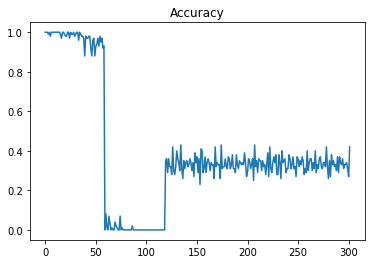

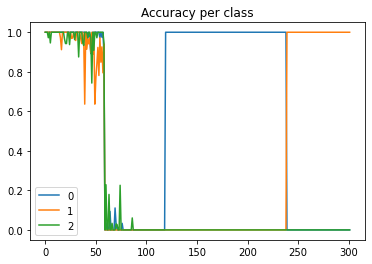

Number of clusters = 4
Number of clusters = 3


77it [00:04, 16.13it/s]

Number of clusters = 4


133it [00:07, 17.93it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


137it [00:07, 10.61it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


139it [00:08,  9.35it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


142it [00:08,  8.31it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


144it [00:08,  7.76it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


146it [00:09,  7.56it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


148it [00:09,  7.55it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


150it [00:09,  7.53it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


152it [00:09,  7.52it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


154it [00:10,  7.47it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


156it [00:10,  7.36it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


158it [00:10,  7.32it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


160it [00:10,  7.38it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


162it [00:11,  7.31it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


164it [00:11,  7.27it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


166it [00:11,  7.19it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


168it [00:12,  7.34it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


170it [00:12,  7.40it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


172it [00:12,  7.43it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


174it [00:12,  7.45it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


177it [00:13,  7.60it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


179it [00:13,  7.67it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


181it [00:13,  7.41it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4

183it [00:14,  7.32it/s]


Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4

185it [00:14,  7.40it/s]


Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4

187it [00:14,  7.46it/s]


Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


188it [00:14,  7.39it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


190it [00:14,  7.29it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


192it [00:15,  7.24it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


194it [00:15,  6.77it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


195it [00:15,  6.54it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


197it [00:16,  6.29it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


199it [00:16,  6.25it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


200it [00:16,  6.31it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


202it [00:16,  6.22it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4

203it [00:17,  6.21it/s]


Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


205it [00:17,  6.23it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4

206it [00:17,  6.15it/s]


Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


208it [00:17,  6.08it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


210it [00:18,  6.13it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4

211it [00:18,  6.14it/s]


Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


213it [00:18,  6.19it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


215it [00:18,  6.14it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


216it [00:19,  6.14it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


218it [00:19,  6.15it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


220it [00:19,  6.06it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


221it [00:19,  6.01it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


223it [00:20,  5.99it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


225it [00:20,  6.12it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4

226it [00:20,  6.13it/s]


Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


228it [00:21,  6.15it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


230it [00:21,  6.17it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


231it [00:21,  6.08it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


233it [00:21,  6.14it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


234it [00:22,  6.15it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


236it [00:22,  6.23it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


237it [00:22,  6.19it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


239it [00:22,  6.25it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


241it [00:23,  7.62it/s]

Number of clusters = 4
Number of clusters = 4
Number of clusters = 4


245it [00:23,  9.15it/s]

Number of clusters = 4
Number of clusters = 4
Number of clusters = 4


248it [00:23,  9.55it/s]

Number of clusters = 4
Number of clusters = 4
Number of clusters = 4

249it [00:23,  9.45it/s]


Number of clusters = 4
Number of clusters = 4


252it [00:24,  9.67it/s]

Number of clusters = 4
Number of clusters = 4
Number of clusters = 4


255it [00:24,  8.58it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


257it [00:24,  7.98it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


258it [00:24,  7.83it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


260it [00:25,  7.64it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


262it [00:25,  7.44it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


264it [00:25,  7.37it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


267it [00:26,  7.52it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4

269it [00:26,  7.45it/s]


Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


271it [00:26,  7.49it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


273it [00:26,  7.38it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


275it [00:27,  7.35it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4


277it [00:27,  7.25it/s]

Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


279it [00:27,  7.25it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


281it [00:28,  7.24it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


283it [00:28,  7.42it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


285it [00:28,  7.47it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4

287it [00:28,  7.50it/s]


Number of clusters = 3
Number of clusters = 4
Number of clusters = 3
Number of clusters = 4

289it [00:29,  7.50it/s]


Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


291it [00:29,  7.27it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


292it [00:29,  7.08it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


294it [00:29,  7.23it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


296it [00:30,  7.29it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


298it [00:30,  7.31it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


300it [00:30,  7.28it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


302it [00:30,  9.76it/s]


Number of clusters = 4
Number of clusters = 3
Time elapsed: 30.9618079662323


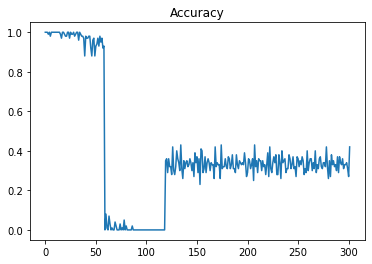

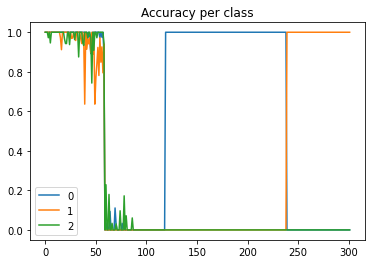

Number of clusters = 4
Number of clusters = 3


77it [00:04, 16.72it/s]

Number of clusters = 4


133it [00:07, 17.72it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


135it [00:07, 12.65it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


137it [00:07, 10.55it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


139it [00:08,  9.31it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


142it [00:08,  8.42it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


144it [00:08,  7.92it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


146it [00:09,  7.51it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


148it [00:09,  7.48it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


150it [00:09,  7.46it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


152it [00:09,  7.36it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


154it [00:10,  7.18it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


156it [00:10,  7.10it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


158it [00:10,  7.22it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


160it [00:10,  7.35it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


162it [00:11,  7.40it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


164it [00:11,  7.37it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


166it [00:11,  7.39it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


168it [00:12,  7.33it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


170it [00:12,  7.33it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


172it [00:12,  7.33it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


174it [00:12,  7.23it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


177it [00:13,  7.51it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


179it [00:13,  7.60it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


181it [00:13,  7.61it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


183it [00:14,  7.41it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


185it [00:14,  7.42it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


186it [00:14,  7.28it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


188it [00:14,  7.29it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


190it [00:15,  7.33it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


192it [00:15,  7.47it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


194it [00:15,  7.20it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


196it [00:15,  6.74it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


198it [00:16,  6.53it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4

199it [00:16,  6.52it/s]


Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


201it [00:16,  6.43it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


203it [00:17,  6.41it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


204it [00:17,  6.45it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


206it [00:17,  6.24it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


208it [00:17,  6.23it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


209it [00:17,  6.18it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


211it [00:18,  6.28it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


213it [00:18,  6.28it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


214it [00:18,  6.23it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


216it [00:19,  6.22it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


218it [00:19,  6.28it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4

219it [00:19,  6.24it/s]


Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


221it [00:19,  6.24it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


223it [00:20,  6.28it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


224it [00:20,  6.26it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


226it [00:20,  6.31it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


227it [00:20,  6.34it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


229it [00:21,  6.33it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


231it [00:21,  6.39it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


232it [00:21,  6.36it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


234it [00:21,  6.37it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4


235it [00:22,  6.22it/s]

Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


237it [00:22,  6.22it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


238it [00:22,  6.06it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2
Number of clusters = 4
Number of clusters = 3


240it [00:22,  6.86it/s]

Number of clusters = 2
Number of clusters = 4
Number of clusters = 4


242it [00:23,  8.13it/s]

Number of clusters = 4
Number of clusters = 4
Number of clusters = 4


246it [00:23,  9.44it/s]

Number of clusters = 4
Number of clusters = 4
Number of clusters = 4


249it [00:23,  9.57it/s]

Number of clusters = 4
Number of clusters = 4


251it [00:23,  9.94it/s]

Number of clusters = 4
Number of clusters = 4
Number of clusters = 4


254it [00:24,  9.37it/s]

Number of clusters = 4
Number of clusters = 4
Number of clusters = 3


255it [00:24,  8.78it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


257it [00:24,  8.12it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


259it [00:24,  7.76it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


261it [00:25,  7.58it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


263it [00:25,  7.59it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


265it [00:25,  7.51it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


267it [00:26,  7.44it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


269it [00:26,  7.39it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


271it [00:26,  7.24it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


273it [00:26,  7.23it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


275it [00:27,  7.23it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


277it [00:27,  7.18it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


279it [00:27,  7.38it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


281it [00:27,  7.41it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


283it [00:28,  7.36it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


285it [00:28,  7.24it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


287it [00:28,  7.34it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


289it [00:29,  7.33it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


292it [00:29,  7.59it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


294it [00:29,  7.33it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


295it [00:29,  7.16it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


297it [00:30,  7.16it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


300it [00:30,  7.55it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


301it [00:30,  7.48it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 4
Number of clusters = 3


302it [00:30,  9.79it/s]


Time elapsed: 30.85566520690918


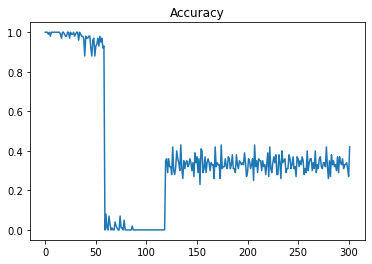

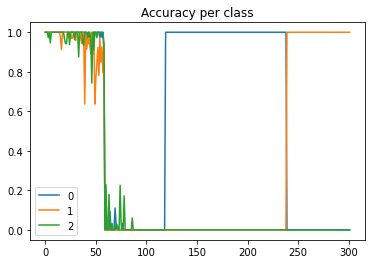

In [41]:
# Obtain averaged results
accuracy_results = []
accuracy_per_class_results = []
for i in range(5):
    fc, accuracies, accuracies_per_class = train_fast_compose(streaming_data_3d, streaming_labels_3d, training_set_size=1500, print_interval=1000, print_label_counts_in_clusters=False)
    accuracy_results.append(accuracies)
    accuracy_per_class_results.append(accuracies_per_class)

Text(0.5, 1.0, 'Accuracy averaged over 5 learning trials')

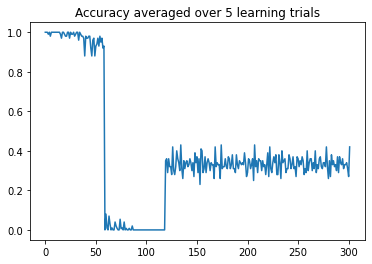

In [42]:
plt.plot(np.array(accuracy_results).mean(axis=0))
plt.title("Accuracy averaged over 5 learning trials")

In [43]:
avg_results_per_class = []
for class_ in range(3):
    result_per_class = np.array([dict_[class_] for dict_ in accuracy_per_class_results if class_ in dict_.keys()], dtype=float)
    avg_result_per_class = np.nanmean(result_per_class, axis=0)
    avg_results_per_class.append(avg_result_per_class)

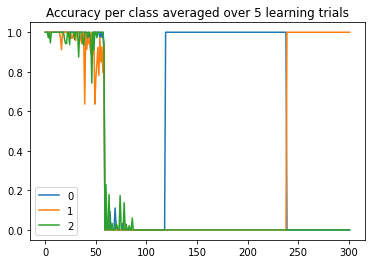

In [44]:
for class_ in range(3):
    plt.plot(avg_results_per_class[class_], label=class_)
    plt.legend()
    plt.title("Accuracy per class averaged over 5 learning trials")